![image](cnn_architecture.png)

In [4]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 320 parameters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 18496 parameters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.dense_layers = nn.Sequential(
            nn.Linear(7*7*64, 128), # 401536 parameters
            nn.ReLU(),
            nn.Linear(128, 10) # 1290 parameters
        )
        # total parameter count = 421642 parameters

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.dense_layers(x)
        return x

# Create the model
model = CNN()

# Create a loader with the MNIST dataset
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

# Set loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(5):  # Reduced for demonstration
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Training Epoch {epoch+1}, Loss: {loss.item()}')

    # Validation step
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    print(f'Validation Accuracy after Epoch {epoch+1}: {accuracy}%')


Training Epoch 1, Loss: 0.7073943614959717
Validation Accuracy after Epoch 1: 84.95%
Training Epoch 2, Loss: 0.4925857186317444
Validation Accuracy after Epoch 2: 82.29%
Training Epoch 3, Loss: 0.20065650343894958
Validation Accuracy after Epoch 3: 92.48%
Training Epoch 4, Loss: 0.22239908576011658
Validation Accuracy after Epoch 4: 93.96%
Training Epoch 5, Loss: 0.1901601254940033
Validation Accuracy after Epoch 5: 94.54%


Note: you may need to restart the kernel to use updated packages.


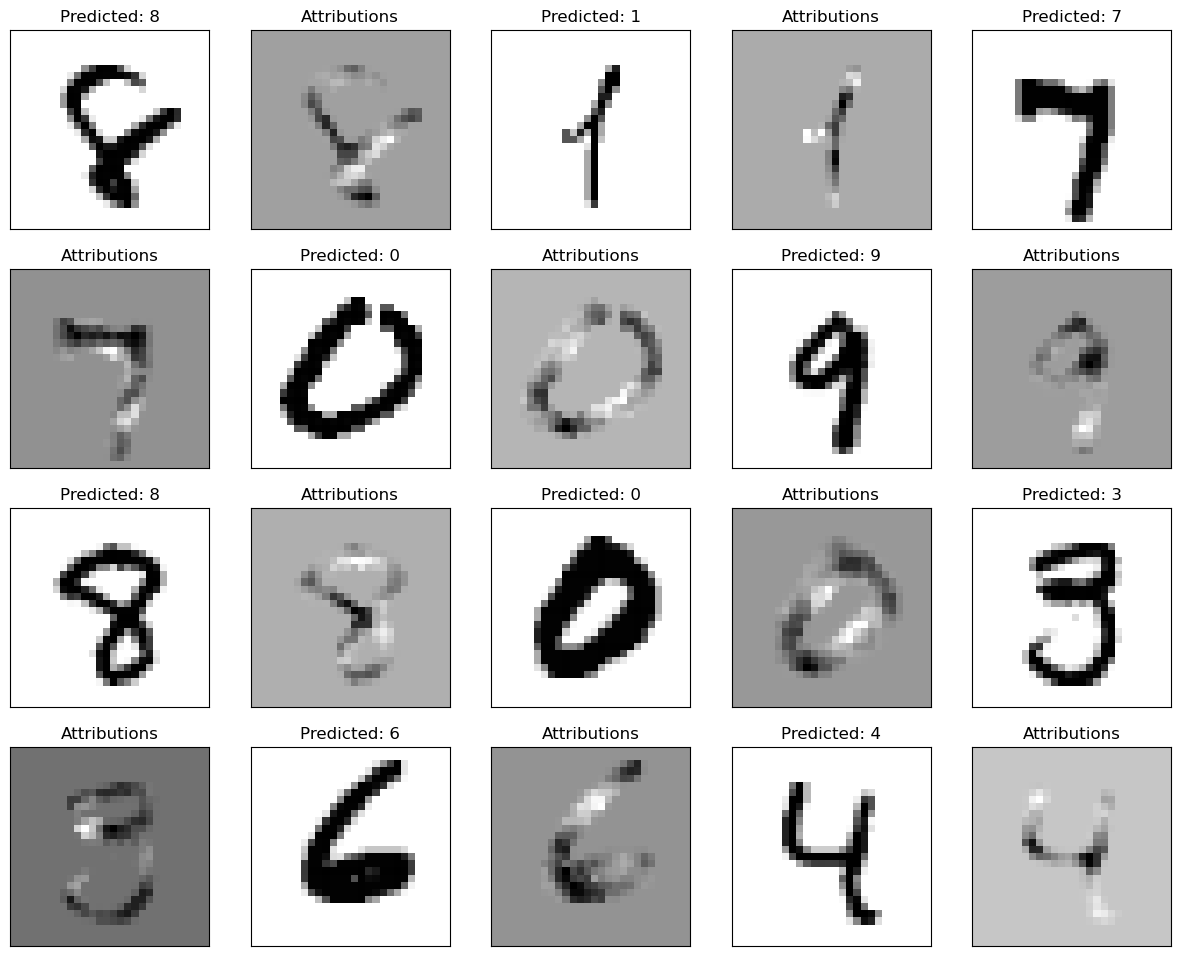

In [5]:
%pip install captum

from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# Inference
model.eval()
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
images, labels = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images)

_, predicted = torch.max(outputs, 1)

# Integrated Gradients
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(images, target=predicted, return_convergence_delta=True)

# Plot the images with the predicted labels and attributions
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i*2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.title('Predicted: ' + str(predicted[i].item()))
    
    plt.subplot(5, 5, i*2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(attributions[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.title('Attributions')
plt.show()